# Set up MATTER+LBT 1

## Model setup

Add some details here

In [1]:
import subprocess

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from scipy.linalg import lapack
from scipy import stats
import emcee
import numpy as np

import os
import pickle
from pathlib import Path

import src.reader as Reader

## Step 1: prepare input pickle file

### Load stuff from text files

In [2]:
# Read data files
RawData1 = Reader.ReadData('input/MATTERLBT1/Data_PHENIX_AuAu200_RAACharged_0to10_2013.dat')
RawData2 = Reader.ReadData('input/MATTERLBT1/Data_PHENIX_AuAu200_RAACharged_40to50_2013.dat')
RawData3 = Reader.ReadData('input/MATTERLBT1/Data_ATLAS_PbPb2760_RAACharged_0to5_2015.dat')
RawData4 = Reader.ReadData('input/MATTERLBT1/Data_ATLAS_PbPb2760_RAACharged_30to40_2015.dat')
RawData5 = Reader.ReadData('input/MATTERLBT1/Data_CMS_PbPb5020_RAACharged_0to10_2017.dat')
RawData6 = Reader.ReadData('input/MATTERLBT1/Data_CMS_PbPb5020_RAACharged_30to50_2017.dat')

# Read covariance
# RawCov1 = Reader.ReadCovariance('input/MATTERLBT1/Covariance_PHENIX_AuAu200_RAACharged_0to10_2013_PHENIX_AuAu200_RAACharged_0to10_2013_SmallL.dat')
# RawCov2 = Reader.ReadCovariance('input/MATTERLBT1/Covariance_PHENIX_AuAu200_RAACharged_40to50_2013_PHENIX_AuAu200_RAACharged_40to50_2013_SmallL.dat')
# RawCov3 = Reader.ReadCovariance('input/MATTERLBT1/Covariance_ATLAS_PbPb2760_RAACharged_0to5_2015_ATLAS_PbPb2760_RAACharged_0to5_2015_SmallL.dat')
# RawCov4 = Reader.ReadCovariance('input/MATTERLBT1/Covariance_ATLAS_PbPb2760_RAACharged_30to40_2015_ATLAS_PbPb2760_RAACharged_30to40_2015_SmallL.dat')
# RawCov5 = Reader.ReadCovariance('input/MATTERLBT1/Covariance_CMS_PbPb5020_RAACharged_0to10_2017_CMS_PbPb5020_RAACharged_0to10_2017_SmallL.dat')
# RawCov6 = Reader.ReadCovariance('input/MATTERLBT1/Covariance_CMS_PbPb5020_RAACharged_30to50_2017_CMS_PbPb5020_RAACharged_30to50_2017_SmallL.dat')

# Read design points
RawDesign = Reader.ReadDesign('input/MATTERLBT1/Design.dat')

# Read model prediction
RawPrediction1 = Reader.ReadPrediction('input/MATTERLBT1/Prediction_PHENIX_AuAu200_RAACharged_0to10_2013.dat')
RawPrediction2 = Reader.ReadPrediction('input/MATTERLBT1/Prediction_PHENIX_AuAu200_RAACharged_40to50_2013.dat')
RawPrediction3 = Reader.ReadPrediction('input/MATTERLBT1/Prediction_ATLAS_PbPb2760_RAACharged_0to5_2015.dat')
RawPrediction4 = Reader.ReadPrediction('input/MATTERLBT1/Prediction_ATLAS_PbPb2760_RAACharged_30to40_2015.dat')
RawPrediction5 = Reader.ReadPrediction('input/MATTERLBT1/Prediction_CMS_PbPb5020_RAACharged_0to10_2017.dat')
RawPrediction6 = Reader.ReadPrediction('input/MATTERLBT1/Prediction_CMS_PbPb5020_RAACharged_30to50_2017.dat')

### Run this block for RHIC + LHC

In [3]:
# Initialize empty dictionary
AllData = {}

# Basic information
AllData["systems"] = ["AuAu200", "PbPb2760", "PbPb5020"]
AllData["keys"] = RawDesign["Parameter"]
AllData["labels"] = RawDesign["Parameter"]
AllData["ranges"] = [(0, 1.5), (0, 1.0), (0, 20), (0, 20), (1, 4)]
AllData["observables"] = [('R_AA', ['C0', 'C1'])]

# Data points
Data = {"AuAu200": {"R_AA": {"C0": RawData1["Data"], "C1": RawData2["Data"]}},
    "PbPb2760": {"R_AA": {"C0": RawData3["Data"], "C1": RawData4["Data"]}},
    "PbPb5020": {"R_AA": {"C0": RawData5["Data"], "C1": RawData6["Data"]}}}

# Model predictions
Prediction = {"AuAu200": {"R_AA": {"C0": {"Y": RawPrediction1["Prediction"], "x": RawData1["Data"]['x']},
                                   "C1": {"Y": RawPrediction2["Prediction"], "x": RawData2["Data"]['x']}}},
             "PbPb2760": {"R_AA": {"C0": {"Y": RawPrediction3["Prediction"], "x": RawData3["Data"]['x']},
                                   "C1": {"Y": RawPrediction4["Prediction"], "x": RawData4["Data"]['x']}}},
             "PbPb5020": {"R_AA": {"C0": {"Y": RawPrediction5["Prediction"], "x": RawData5["Data"]['x']},
                                   "C1": {"Y": RawPrediction6["Prediction"], "x": RawData6["Data"]['x']}}}}

# Covariance matrices - the indices are [system][measurement1][measurement2], each one is a block of matrix
Covariance = Reader.InitializeCovariance(Data)
Covariance["AuAu200"][("R_AA", "C0")][("R_AA", "C0")] = Reader.EstimateCovariance(RawData1, RawData1, {"default": 0.2})
Covariance["AuAu200"][("R_AA", "C1")][("R_AA", "C1")] = Reader.EstimateCovariance(RawData2, RawData2, {"default": 0.2})
Covariance["PbPb2760"][("R_AA", "C0")][("R_AA", "C0")] = Reader.EstimateCovariance(RawData3, RawData3, {"default": 0.2})
Covariance["PbPb2760"][("R_AA", "C1")][("R_AA", "C1")] = Reader.EstimateCovariance(RawData4, RawData4, {"default": 0.2})
Covariance["PbPb5020"][("R_AA", "C0")][("R_AA", "C0")] = Reader.EstimateCovariance(RawData5, RawData5, {"default": 0.2})
Covariance["PbPb5020"][("R_AA", "C1")][("R_AA", "C1")] = Reader.EstimateCovariance(RawData6, RawData6, {"default": 0.2})
# Covariance["PbPb5020"][("R_AA", "C0")][("R_AA", "C1")] = Reader.EstimateCovariance(RawData5, RawData6, {"default": 0.2})

# This is how we can supply external pre-generated matrices
# Covariance["AuAu200"][("R_AA", "C0")][("R_AA", "C0")] = RawCov1["Matrix"]


# Assign data to the dictionary
AllData["design"] = RawDesign["Design"]
AllData["model"] = Prediction
AllData["data"] = Data
AllData["cov"] = Covariance

# Save to the desired pickle file
with open('input/default.p', 'wb') as handle:
    pickle.dump(AllData, handle, protocol = pickle.HIGHEST_PROTOCOL)

### Optional: clean past files

In [4]:
# Clean past MCMC samples
if os.path.exists('cache/mcmc_chain.hdf'):
    os.remove("cache/mcmc_chain.hdf")

# Clean past emulator
for system in AllData["systems"]:
    if os.path.exists('cache/emulator/' + system + ".pkl"):
        os.remove('cache/emulator/' + system + ".pkl")

## Step 2: run emulator

In [5]:
! python3 -m src.emulator --retrain --npc 10

[INFO][emulator] training emulator for system AuAu200 (10 PC, 0 restarts)
[ 1.5  1.  20.  20.   3. ]
[INFO][emulator] writing cache file cache/emulator/AuAu200.pkl
AuAu200
10 PCs explain 0.99972 of variance
GP 0: 0.98046 of variance, LML = 10.68, kernel: 1.93**2 * Matern(length_scale=[1.32, 4.27, 69.3, 71.7, 30], nu=1.5)
GP 1: 0.01481 of variance, LML = -57.35, kernel: 1.28**2 * Matern(length_scale=[0.167, 10, 22.9, 27.1, 16.1], nu=1.5)
GP 2: 0.00122 of variance, LML = -87.939, kernel: 1.06**2 * Matern(length_scale=[0.706, 0.467, 9.17, 11.5, 0.875], nu=1.5)
GP 3: 0.00077 of variance, LML = -98.139, kernel: 1**2 * Matern(length_scale=[0.479, 0.103, 3.08, 200, 0.3], nu=1.5)
GP 4: 0.00061 of variance, LML = -97.595, kernel: 0.989**2 * Matern(length_scale=[15, 0.1, 3.43, 2, 0.3], nu=1.5)
GP 5: 0.00055 of variance, LML = -97.698, kernel: 0.994**2 * Matern(length_scale=[0.396, 0.276, 6.78, 4.53, 0.3], nu=1.5)
GP 6: 0.00049 of variance, LML = -98.429, kernel: 1**2 * Matern(length_scale=[0.473

In [6]:
from src import lazydict, emulator
EmulatorAuAu200 = emulator.Emulator.from_cache('AuAu200')
EmulatorPbPb2760 = emulator.Emulator.from_cache('PbPb2760')
EmulatorPbPb5020 = emulator.Emulator.from_cache('PbPb5020')

## Step 3: MCMC sampling

In [7]:
if os.path.exists('cache/mcmc_chain.hdf'):
    os.remove("cache/mcmc_chain.hdf")
! python3 -m src.mcmc --nwalkers 500 --nburnsteps 500 1000

[INFO][mcmc] no existing chain found, starting initial burn-in
[INFO][mcmc] running 500 walkers for 250 steps
[INFO][mcmc] step 25: acceptance fraction: mean 0.3088, std 0.1375, min 0.0000, max 0.6800
[INFO][mcmc] step 50: acceptance fraction: mean 0.3014, std 0.1192, min 0.0000, max 0.5800
[INFO][mcmc] step 75: acceptance fraction: mean 0.3011, std 0.1076, min 0.0000, max 0.5467
[INFO][mcmc] step 100: acceptance fraction: mean 0.3042, std 0.1029, min 0.0100, max 0.4900
[INFO][mcmc] step 125: acceptance fraction: mean 0.3107, std 0.1016, min 0.0080, max 0.5120
[INFO][mcmc] step 150: acceptance fraction: mean 0.3158, std 0.1015, min 0.0067, max 0.5267
[INFO][mcmc] step 175: acceptance fraction: mean 0.3195, std 0.1002, min 0.0114, max 0.5143
[INFO][mcmc] step 200: acceptance fraction: mean 0.3233, std 0.1001, min 0.0100, max 0.4900
[INFO][mcmc] step 225: acceptance fraction: mean 0.3257, std 0.0998, min 0.0089, max 0.4800
[INFO][mcmc] step 250: acceptance fraction: mean 0.3282, std 0.09

## Step 4: Analyze posterior samples

In [8]:
from src import mcmc
chain = mcmc.Chain()
MCMCSamples = chain.load()

TransformedSamples = np.copy(MCMCSamples)
TransformedSamples[:,0] = MCMCSamples[:,0] * MCMCSamples[:,1]
TransformedSamples[:,1] = MCMCSamples[:,0] - MCMCSamples[:,0] * MCMCSamples[:,1]
TransformedSamples[:,2] = MCMCSamples[:,2]
TransformedSamples[:,3] = MCMCSamples[:,3]
TransformedSamples[:,4] = MCMCSamples[:,4]

In [9]:
! python3 -m src.plots --help

usage: plots.py [-h] [PLOT [PLOT ...]]

generate plots

positional arguments:
  PLOT        {observables_design, observables_posterior, posterior, design,
              gp, diag_emu} (default: all)

optional arguments:
  -h, --help  show this help message and exit


In [10]:
! python3 -m src.plots posterior gp diag_emu

[INFO][plots] generating plot: posterior
[INFO][plots] wrote plots/posterior.pdf
[INFO][plots] generating plot: gp
[INFO][plots] wrote plots/gp.pdf
[INFO][plots] generating plot: diag_emu
[INFO][plots] wrote plots/diag_emu.pdf


## Step 5: adding all sorts of plots

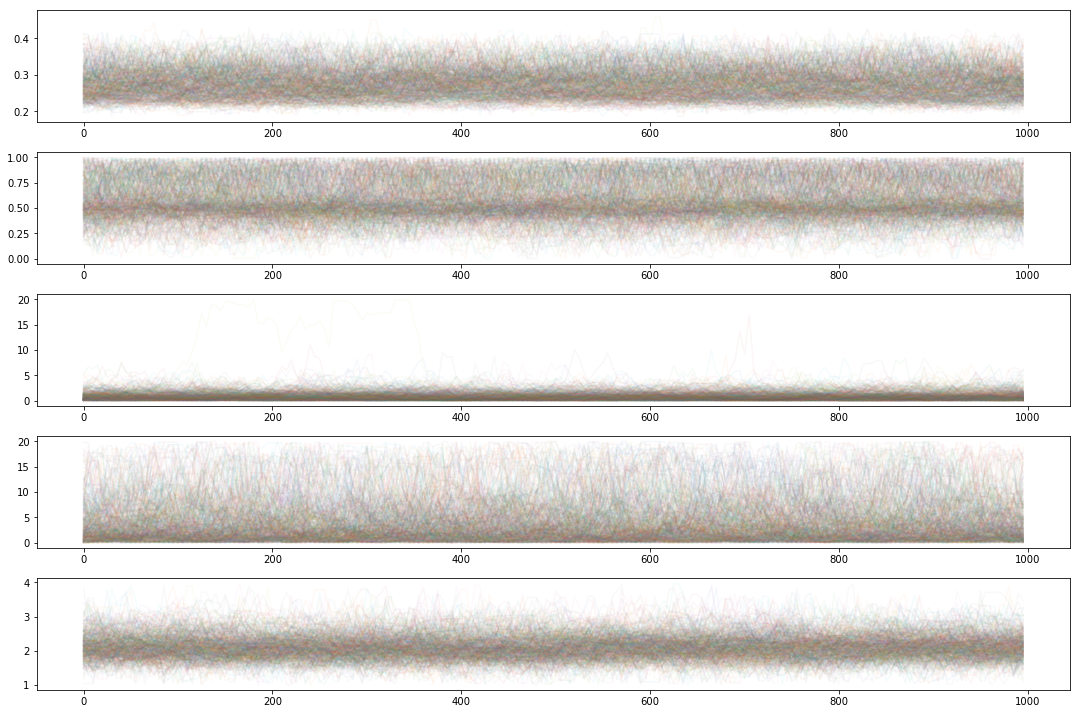

In [11]:
with chain.dataset() as d:
    W = d.shape[0]     # number of walkers
    S = d.shape[1]     # number of steps
    N = d.shape[2]     # number of paramters
    T = int(S / 200)   # "thinning"
    A = 20 / W
    figure, axes = plt.subplots(figsize = (15, 2 * N), ncols = 1, nrows = N)
    for i, ax in enumerate(axes):
        for j in range(0, W):
            ax.plot(range(0, S, T), d[j, ::T, i], alpha = A)
    plt.tight_layout(True)
    plt.savefig('plots/MCMCSamples.pdf', dpi = 192)

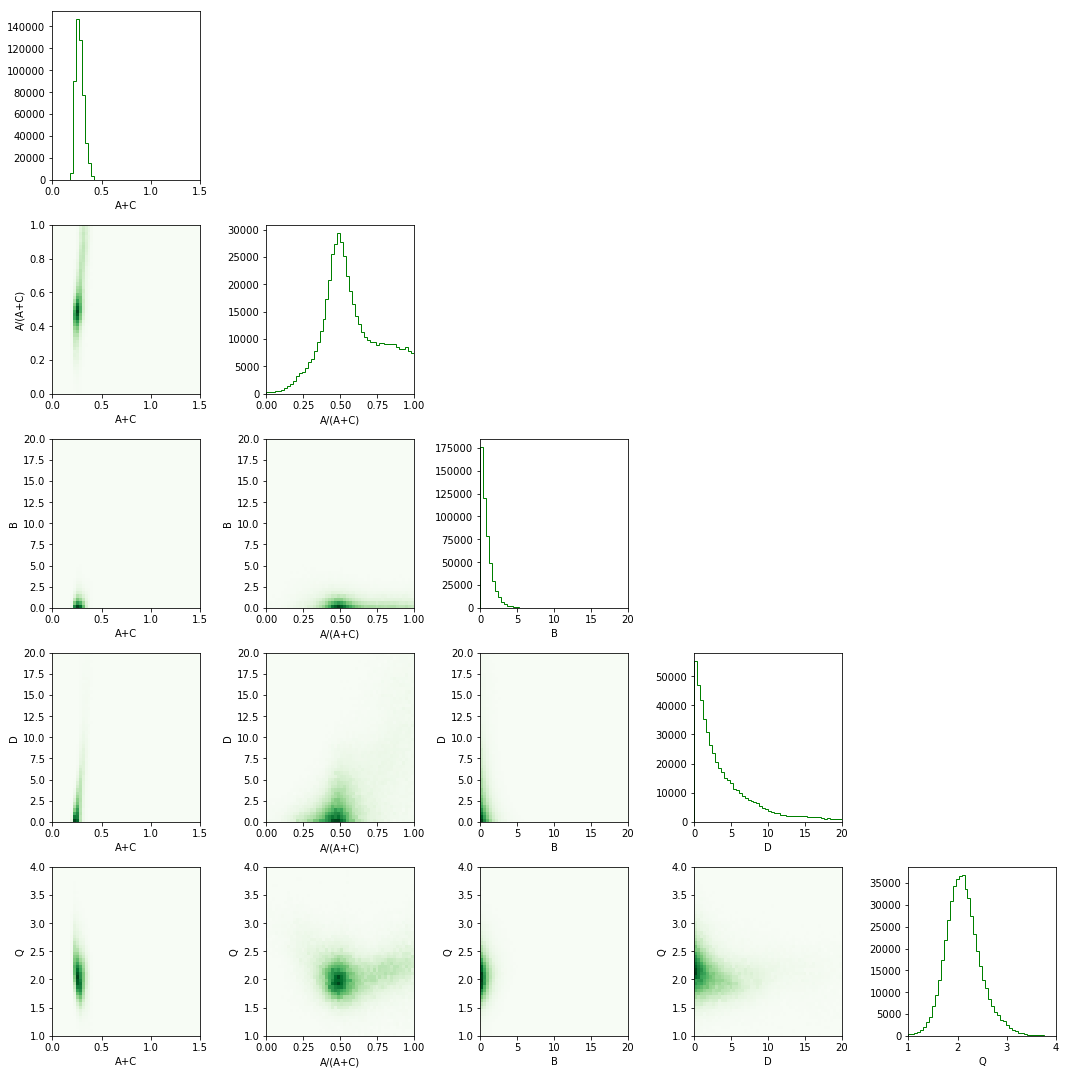

In [12]:
NDimension = len(AllData["labels"])
Ranges = np.array(AllData["ranges"]).T
figure, axes = plt.subplots(figsize = (3 * NDimension, 3 * NDimension), ncols = NDimension, nrows = NDimension)
Names = AllData["labels"]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i==j:
            ax.hist(MCMCSamples[:,i], bins=50,
                    range=Ranges[:,i], histtype='step', color='green')
            ax.set_xlabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
        if i>j:
            ax.hist2d(MCMCSamples[:, j], MCMCSamples[:, i], 
                      bins=50, range=[Ranges[:,j], Ranges[:,i]], 
                      cmap='Greens')
            ax.set_xlabel(Names[j])
            ax.set_ylabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
            ax.set_ylim(*Ranges[:,i])
        if i<j:
            ax.axis('off')
plt.tight_layout(True)
plt.savefig('plots/Correlation.pdf', dpi = 192)
# figure

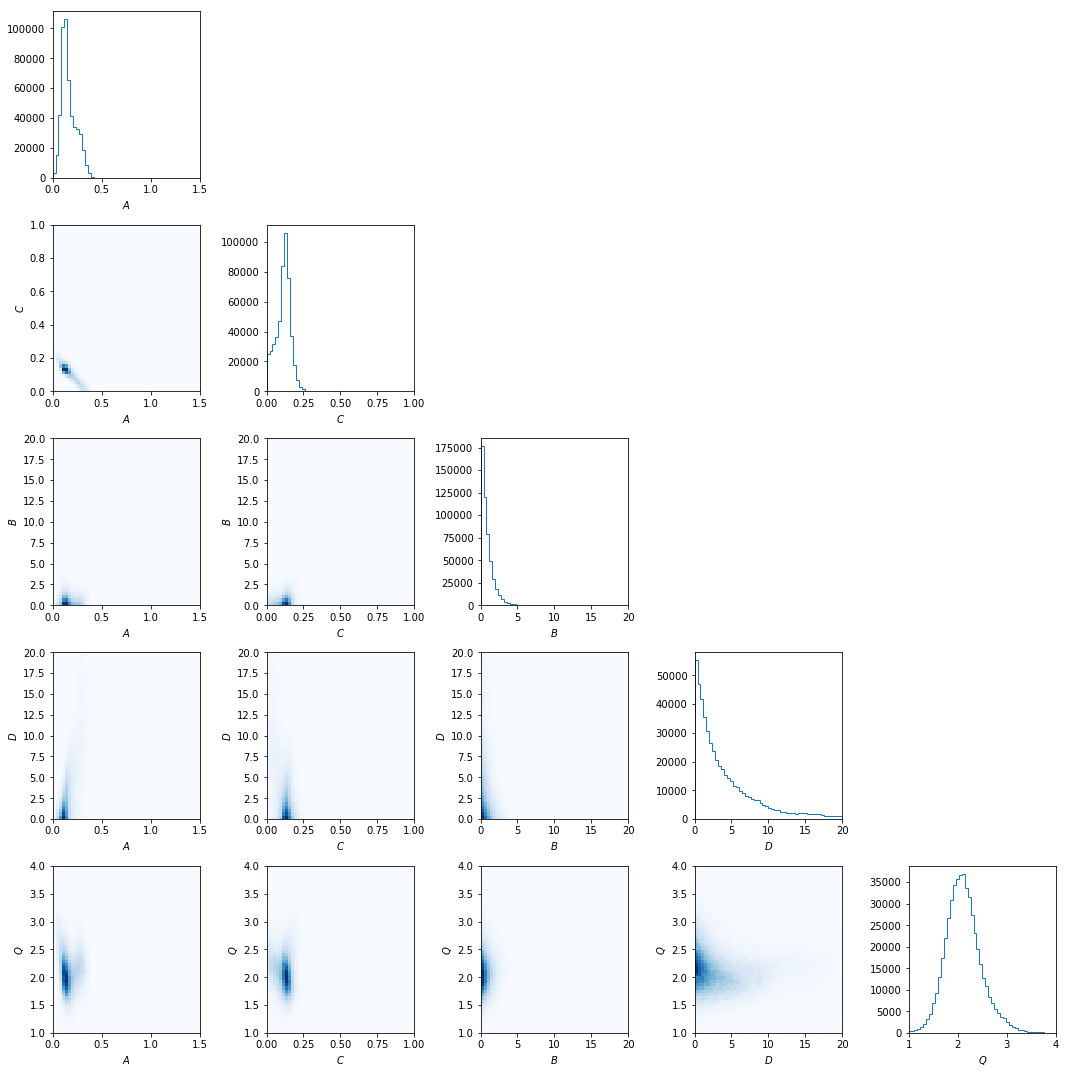

In [13]:
NDimension = 5
Ranges = np.array(AllData["ranges"]).T
figure, axes = plt.subplots(figsize = (15, 15), ncols = NDimension, nrows = NDimension)
Names = [r"$A$", r"$C$", r"$B$", r"$D$", r"$Q$", r"$P_6$"]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i==j:
            ax.hist(TransformedSamples[:,i], bins=50,
                    range=Ranges[:,i], histtype='step')
            ax.set_xlabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
        if i>j:
            ax.hist2d(TransformedSamples[:, j], TransformedSamples[:, i], 
                      bins=50, range=[Ranges[:,j], Ranges[:,i]], 
                      cmap='Blues')
            ax.set_xlabel(Names[j])
            ax.set_ylabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
            ax.set_ylim(*Ranges[:,i])
        if i<j:
            ax.axis('off')
plt.tight_layout(True)
plt.savefig('plots/TransformedCorrelation.pdf', dpi = 192)
# figure

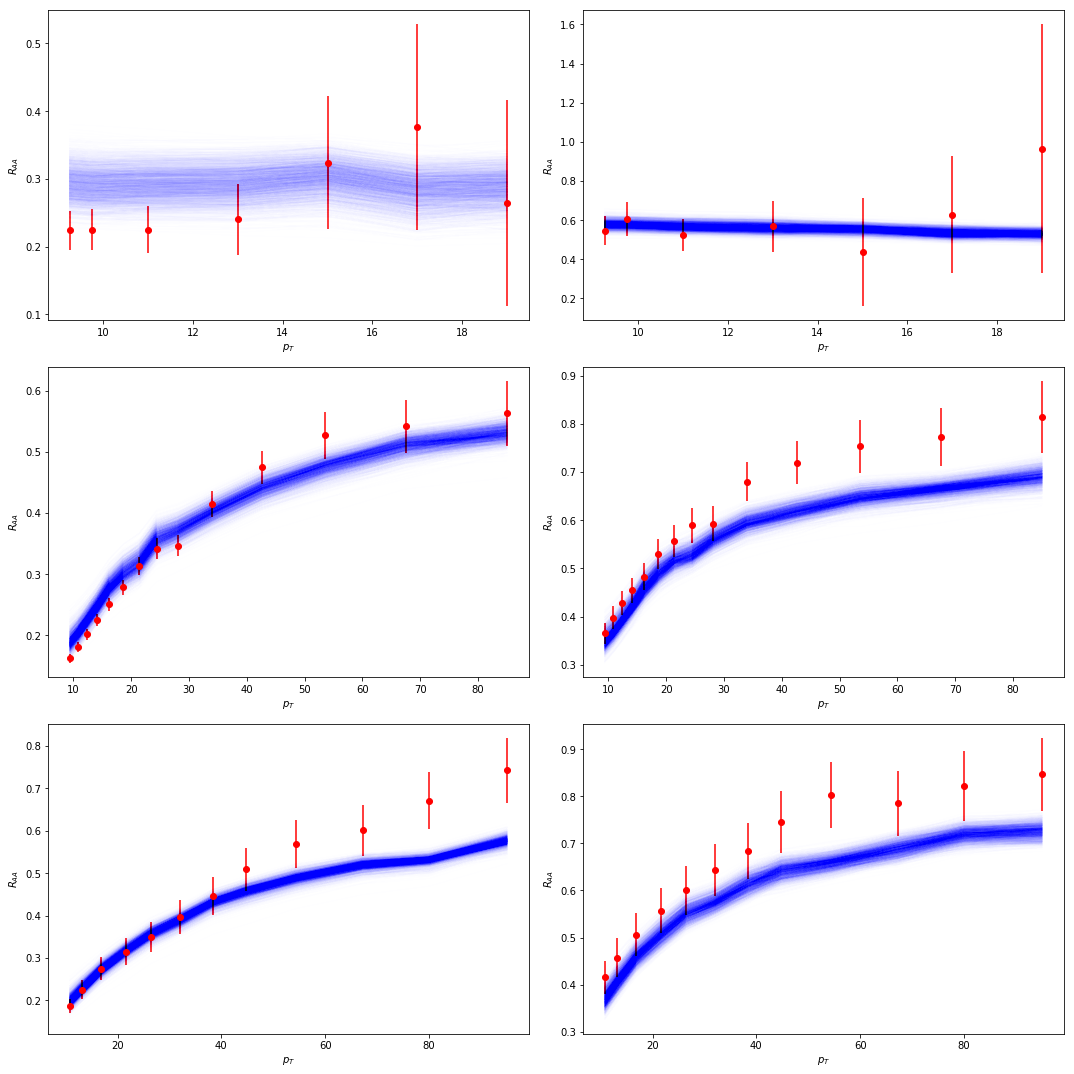

In [14]:
Examples = MCMCSamples[ np.random.choice(range(len(MCMCSamples)), 2500), :]

TempPrediction = {"AuAu200": EmulatorAuAu200.predict(Examples),
                 "PbPb2760": EmulatorPbPb2760.predict(Examples),
                 "PbPb5020": EmulatorPbPb5020.predict(Examples)}

SystemCount = len(AllData["systems"])

figure, axes = plt.subplots(figsize = (15, 5 * SystemCount), ncols = 2, nrows = SystemCount)

for s1 in range(0, SystemCount):
    for s2 in range(0, 2):
        axes[s1][s2].set_xlabel(r"$p_{T}$")
        axes[s1][s2].set_ylabel(r"$R_{AA}$")
        
        S1 = AllData["systems"][s1]
        O  = AllData["observables"][0][0]
        S2 = AllData["observables"][0][1][s2]
        
        DX = AllData["data"][S1][O][S2]['x']
        DY = AllData["data"][S1][O][S2]['y']
        DE = np.sqrt(AllData["data"][S1][O][S2]['yerr']['stat'][:,0]**2 + AllData["data"][S1][O][S2]['yerr']['sys'][:,0]**2)
                
        for i, y in enumerate(TempPrediction[S1][O][S2]):
            axes[s1][s2].plot(DX, y, 'b-', alpha=0.005, label="Posterior" if i==0 else '')
        axes[s1][s2].errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements")

plt.tight_layout(True)
figure.savefig('plots/ObservablePosterior.pdf', dpi = 192)
# figure

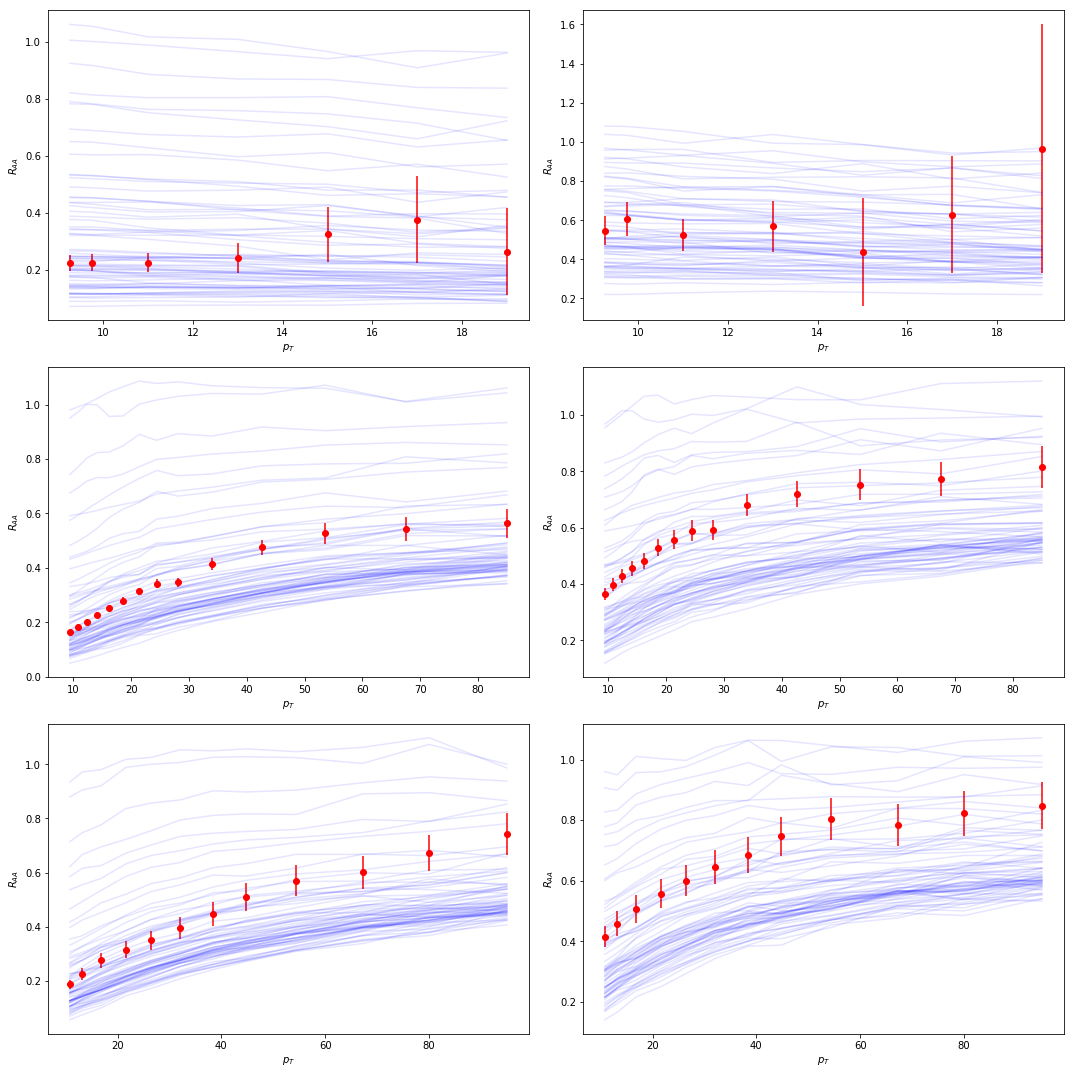

In [15]:
Examples = AllData["design"]

TempPrediction = {"AuAu200": EmulatorAuAu200.predict(Examples),
                 "PbPb2760": EmulatorPbPb2760.predict(Examples),
                 "PbPb5020": EmulatorPbPb5020.predict(Examples)}

SystemCount = len(AllData["systems"])

figure, axes = plt.subplots(figsize = (15, 5 * SystemCount), ncols = 2, nrows = SystemCount)

for s1 in range(0, SystemCount):
    for s2 in range(0, 2):
        axes[s1][s2].set_xlabel(r"$p_{T}$")
        axes[s1][s2].set_ylabel(r"$R_{AA}$")
        
        S1 = AllData["systems"][s1]
        O  = AllData["observables"][0][0]
        S2 = AllData["observables"][0][1][s2]
        
        DX = AllData["data"][S1][O][S2]['x']
        DY = AllData["data"][S1][O][S2]['y']
        DE = np.sqrt(AllData["data"][S1][O][S2]['yerr']['stat'][:,0]**2 + AllData["data"][S1][O][S2]['yerr']['sys'][:,0]**2)
                
        for i, y in enumerate(TempPrediction[S1][O][S2]):
            axes[s1][s2].plot(DX, y, 'b-', alpha=0.1, label="Posterior" if i==0 else '')
        axes[s1][s2].errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements")

plt.tight_layout(True)
figure.savefig('plots/PredictedDesign.pdf', dpi = 192)
# figure

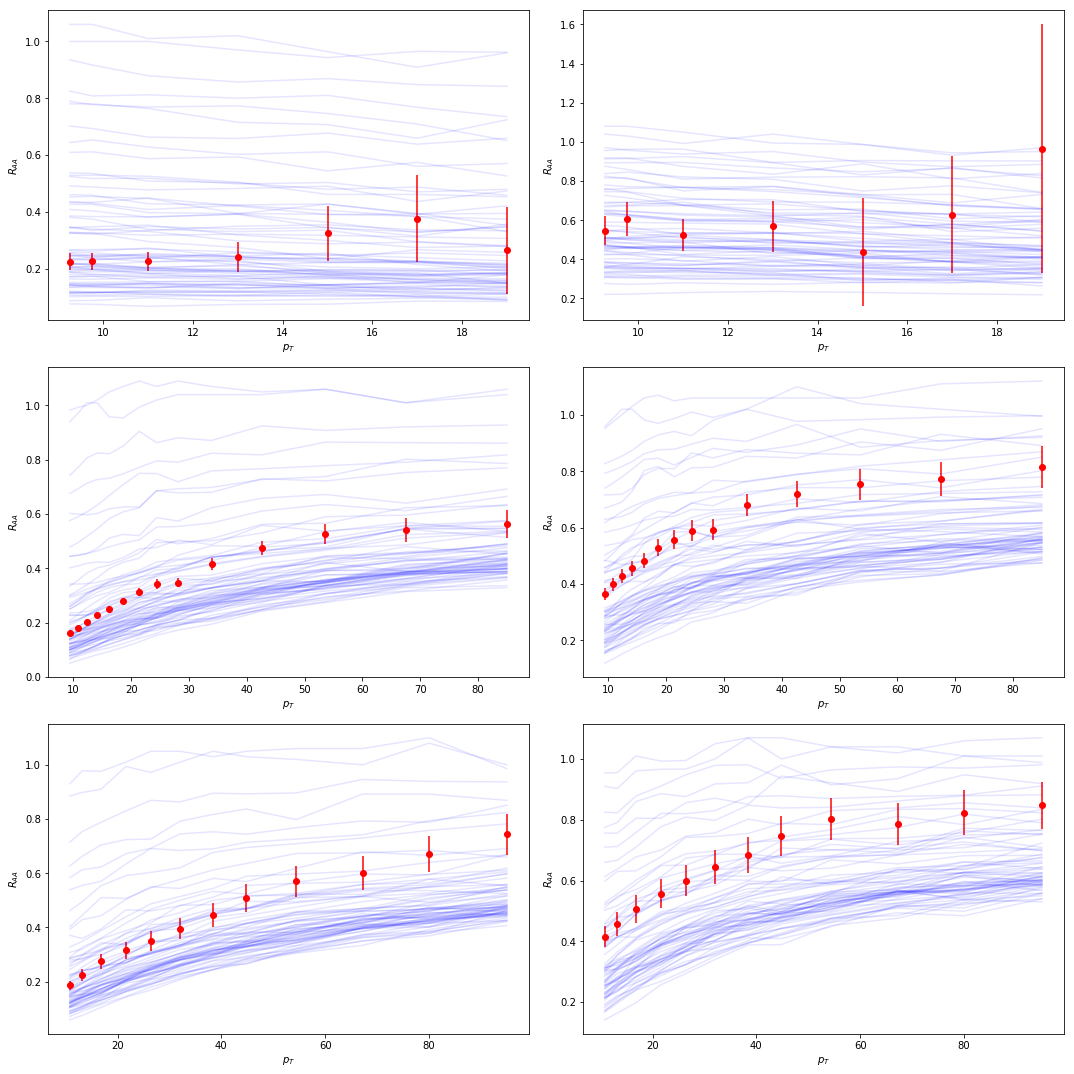

In [16]:
TempPrediction = AllData["model"]

SystemCount = len(AllData["systems"])

figure, axes = plt.subplots(figsize = (15, 5 * SystemCount), ncols = 2, nrows = SystemCount)

for s1 in range(0, SystemCount):
    for s2 in range(0, 2):
        axes[s1][s2].set_xlabel(r"$p_{T}$")
        axes[s1][s2].set_ylabel(r"$R_{AA}$")
        
        S1 = AllData["systems"][s1]
        O  = AllData["observables"][0][0]
        S2 = AllData["observables"][0][1][s2]
        
        DX = AllData["data"][S1][O][S2]['x']
        DY = AllData["data"][S1][O][S2]['y']
        DE = np.sqrt(AllData["data"][S1][O][S2]['yerr']['stat'][:,0]**2 + AllData["data"][S1][O][S2]['yerr']['sys'][:,0]**2)
                
        for i, y in enumerate(TempPrediction[S1][O][S2]['Y']):
            axes[s1][s2].plot(DX, y, 'b-', alpha=0.1, label="Posterior" if i==0 else '')
        axes[s1][s2].errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements")

plt.tight_layout(True)
figure.savefig('plots/Design.pdf', dpi = 192)
# figure

In [17]:
# close all plots to save memory
plt.close('all')

In [18]:
# ! python3 -m src.simpleplots